## Handling imbalanced data problem with SMOTE

### Predicting telecom churn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score,f1_score,recall_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
df=pd.read_csv("c:/csv-ml/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
df.shape

(7043, 21)

In [6]:
df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


# Data cleaning

In [7]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Total charges have to converted from object to numeric. 
### The column contains some noise due to presence of white space



In [8]:

import re
li_charge=[]
    
for item in df["TotalCharges"]:
    if item=="":
        li_charge.append("0")
    elif " " in item:
        li_charge.append(item.replace(" ",""))
    else:
        li_charge.append(item)
df["TotalCharges"]=li_charge
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"])

In [9]:
#missing values analysis

In [10]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

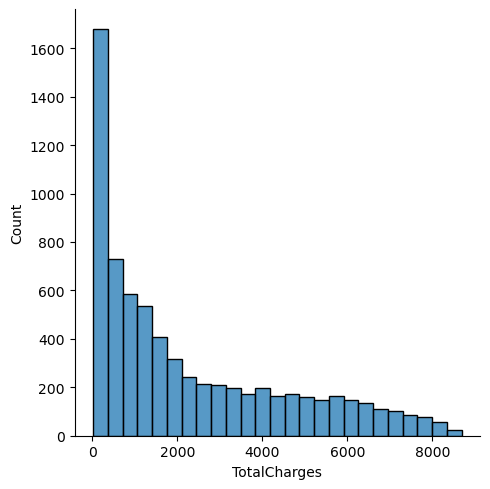

In [11]:
#creating distribution of total charges
sns.displot(df["TotalCharges"])


In [12]:
#filling missing values of totalcharges with mean
df["TotalCharges"].fillna(df["TotalCharges"].median(),inplace=True)

In [13]:
#Verifying the the dtype of TotalCharges
df["TotalCharges"].dtypes

dtype('float64')

## Exploratory data analysis and visualisation

In [14]:
#viewing the distribution of classes in the target column
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

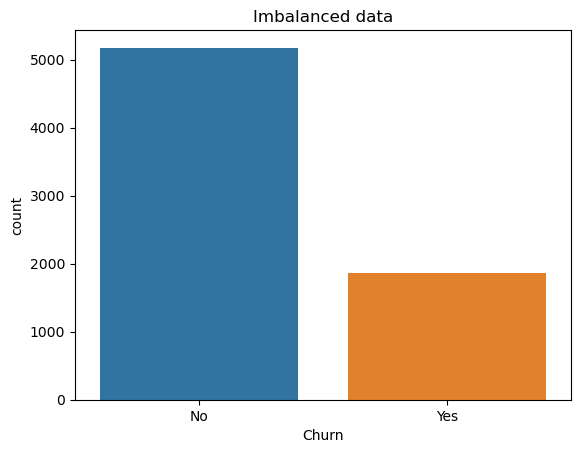

In [15]:
sns.countplot(df["Churn"])
plt.title("Imbalanced data")
plt.show()

In [16]:
#Creating x and y

def feature_selection(data):
    x=data.drop(["customerID","Churn"],axis=1)
    y=data["Churn"]
    return x,y

In [17]:
x,y=feature_selection(df)

In [18]:
#calculating the rows and columns for subplot for analysis of categorical variables
dt=x.dtypes
obj=dt[dt=="object"].index
c=len(obj)//2
r=len(obj)//c
print(r)
print(c)


2
7


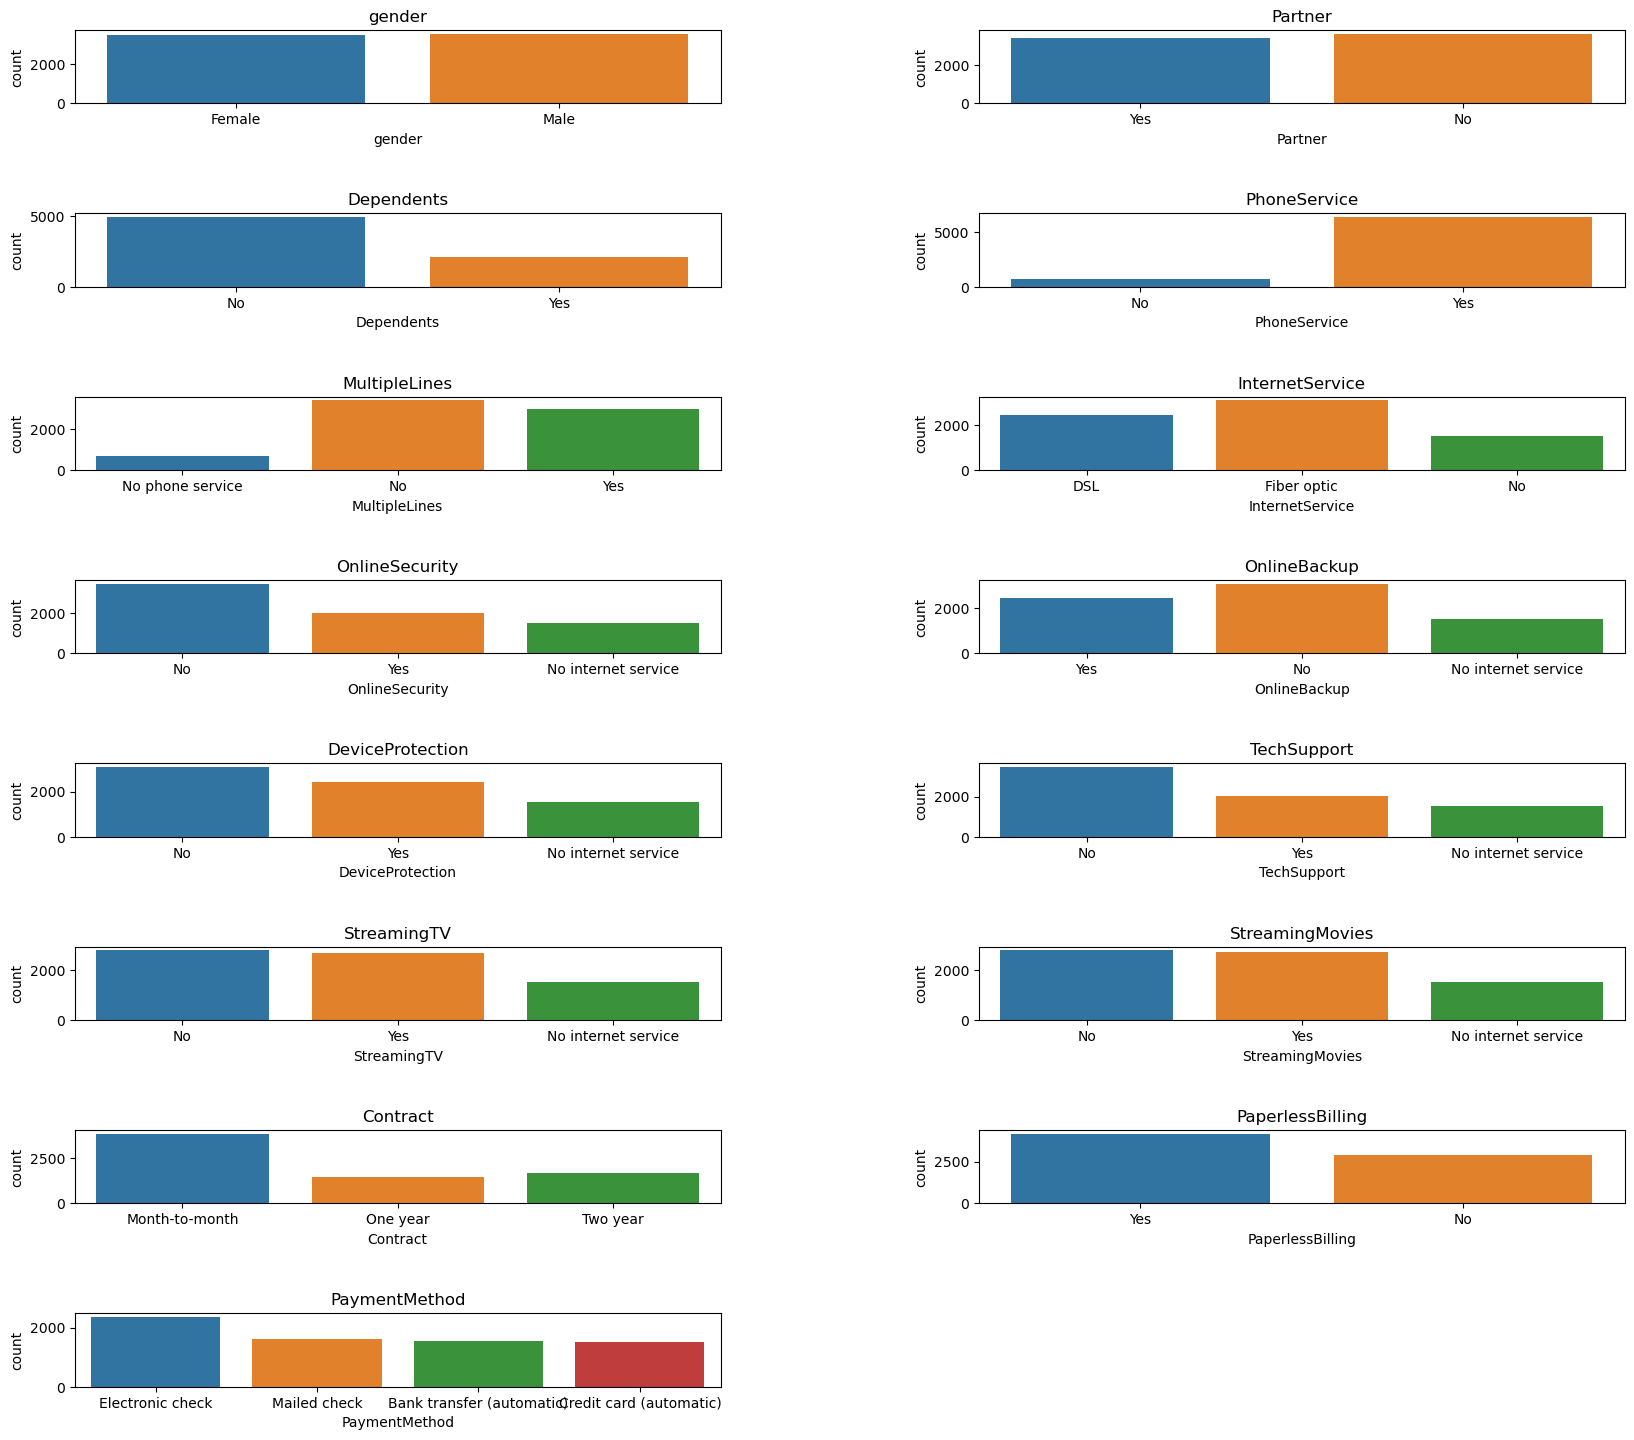

In [19]:
%matplotlib inline
plt.figure(figsize=(20,20))
plt.subplots_adjust( hspace=1.5, wspace=0.4)
for i, c in enumerate(obj, 1):
    
    
    plt.subplot(9,2,i) 
    plt.title(c)
    sns.countplot(c,data=df)

#### From the above plots we can draw the following insights:
#### 1. Number of male and female customers are almost equal.
#### 2. The number of people who  have not listed dependants are more
#### 3. Majority of people have subscribed to phone services and among them 50% of the people have mutiple lines
#### 4. If the sbscribers have taken internet services ,majority have opted for  fiber optic  connection
#### 5. Majority of subscribers have not taken online security and online backup services. So there is a scope of improvement in the area.
#### 6. Majority of people prefer month to month contract 
#### 7. Majority of subscribers prefer paperless billing.
#### 8. Most of the customers prefer to pay through electronic cheque , though other payment methods like mailed check, bank transfer and credit card payments are also popular


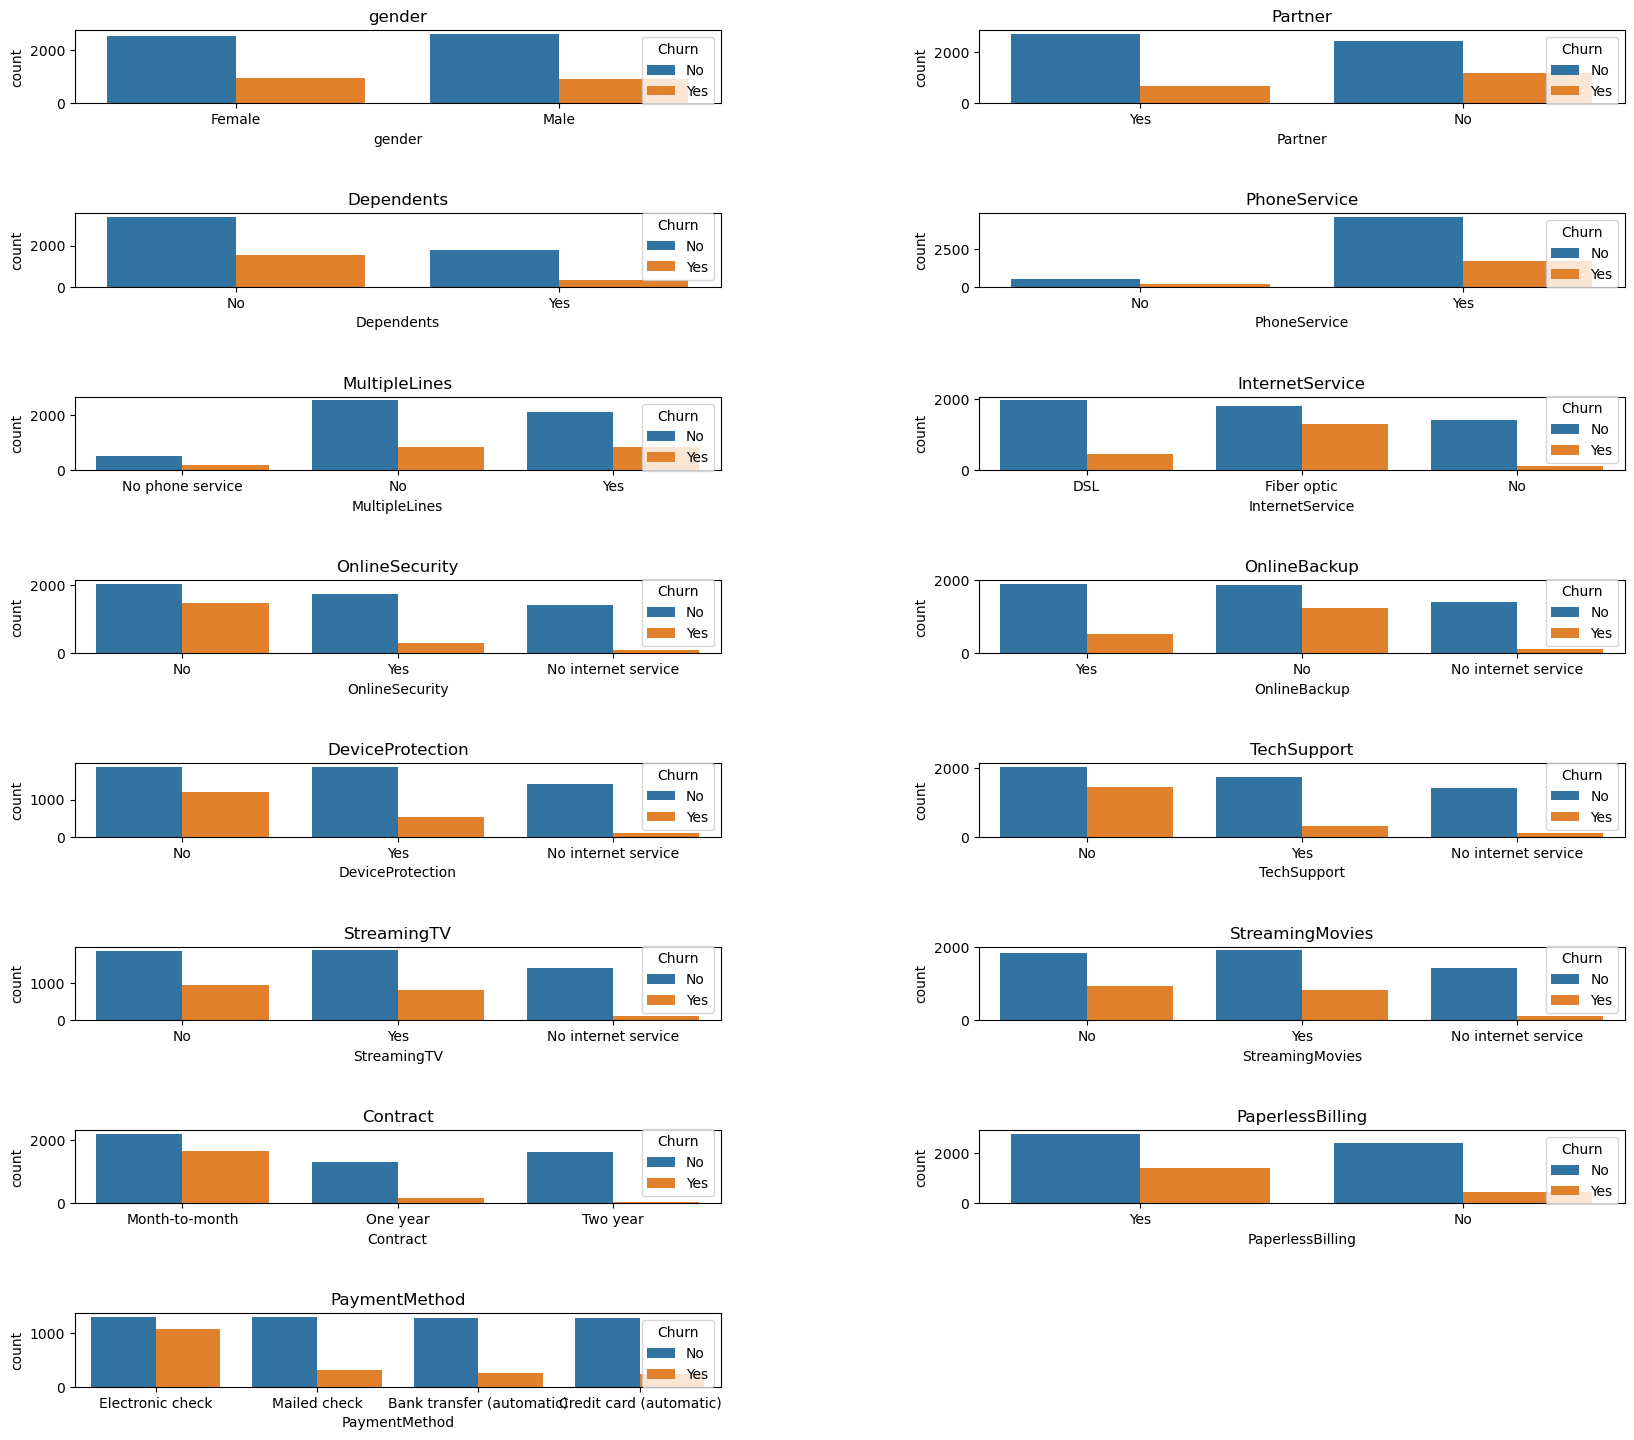

In [20]:
#as we will like to predict the churn ,want to analyse these plots based on churn

%matplotlib inline
plt.figure(figsize=(20,20))
plt.subplots_adjust( hspace=1.5, wspace=0.4)
for i, c in enumerate(obj, 1):
    
    
    plt.subplot(9,2,i) 
    plt.title(c)
    sns.countplot(c,data=df,hue="Churn")

#### The following insights are drawn:
#### 1. The subscibers in 1 year or two year contract are less likely to churn
#### 2. The customers who have not taken device protection,techsupport, online security services
#### are more likely to churn.
#### 3. The customers who have dependants are less likely to churn 


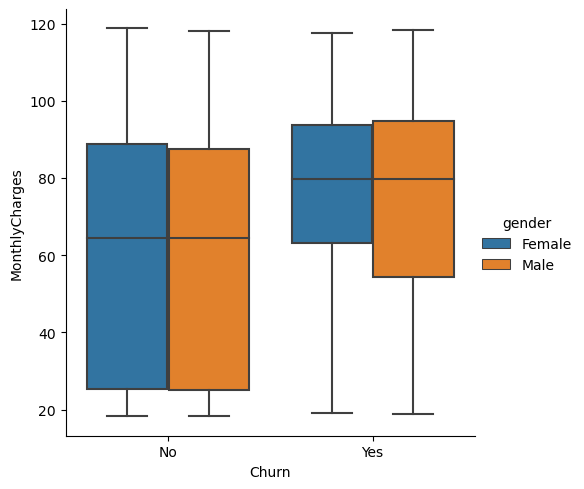

In [21]:
sns.catplot(x="Churn",y="MonthlyCharges",data=df,hue="gender",kind="box")

#### Male and Female customers are almost equal but 
#### majority of customers who are churning are males

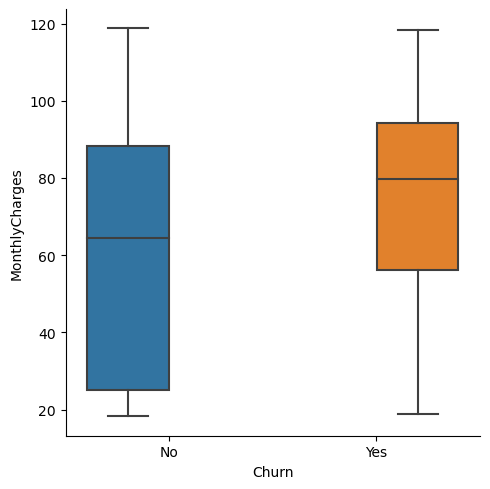

In [22]:
sns.catplot(x="Churn",y="MonthlyCharges",data=df,hue="Churn",kind="box")

##### customers who are paying more monthly charges, are more likely to churn

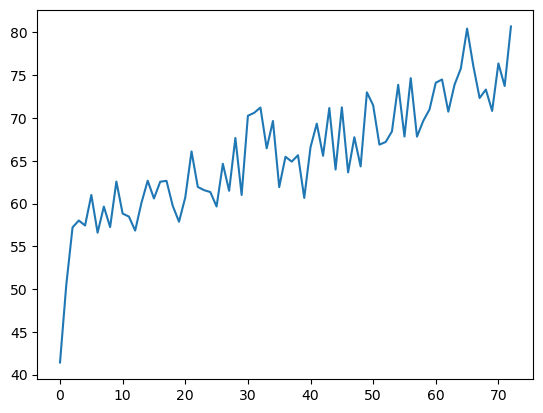

In [23]:
#trend chart of monthly charges as per tenure

tenure_gr=df.groupby("tenure")["MonthlyCharges"].mean()
plt.plot(tenure_gr.index,tenure_gr)

#### The average monthly charges seen to increase with increase in tenure

### Analysing monthly charges based on types of contract with DONUT chart

In [79]:
grp_charge=df.groupby("Contract")["MonthlyCharges"].mean()

In [80]:
grp_charge

Contract
Month-to-month    66.398490
One year          65.048608
Two year          60.770413
Name: MonthlyCharges, dtype: float64

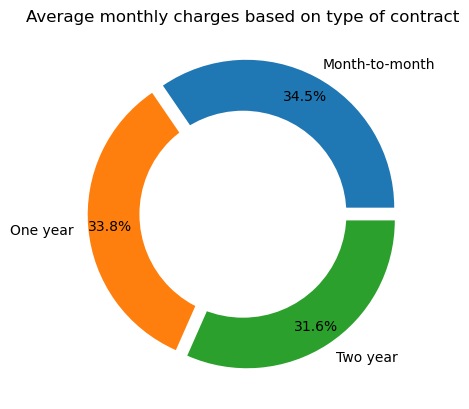

In [84]:
# Pie Chart
# colors
colors = ['#FF0000', '#0000FF', '#FFFF00']
# explosion
explode = (0.05, 0.05, 0.05)

plt.pie(grp_charge, labels=grp_charge.index,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
 
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
 
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
 
# Adding Title of chart
plt.title('Average monthly charges based on type of contract')
 
# Displaying Chart
plt.show()

#### monthly charges are almost same for all contracts

In [ ]:
### Analysing total charges based on payment method with DONUT chart

In [85]:
grp_total=df.groupby("PaymentMethod")["TotalCharges"].mean()

In [86]:
grp_total

PaymentMethod
Bank transfer (automatic)    3077.121017
Credit card (automatic)      3070.296206
Electronic check             2090.868182
Mailed check                 1056.186104
Name: TotalCharges, dtype: float64

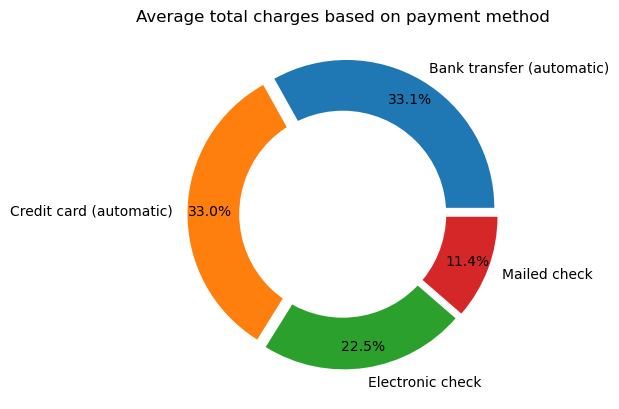

In [89]:
# Pie Chart
# colors

# explosion
explode = (0.05, 0.05,0.05,0.05)

plt.pie(grp_total, labels=grp_total.index,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
 
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
 
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
 
# Adding Title of chart
plt.title('Average total charges based on payment method')
 
# Displaying Chart
plt.show()

In [24]:
#### Encoding the object data types using one hot encoding. One hot encoding gives better result

def encode(x,y):
    
    dt=x.dtypes
    dt_obj=dt[dt=="object"].index
    x_new=pd.get_dummies(x,columns=dt_obj,drop_first=True)
    if y.dtypes=="O":
        y_new=LabelEncoder().fit_transform(y)
    else:
        y_new=y
    return x_new,y_new

In [25]:
#Creating a label encoder also

def encode1(x,y):
    
    dt=x.dtypes
    dt_obj=dt[dt=="object"].index
    for i in dt_obj:
        x[i]=LabelEncoder().fit_transform(x[i])
    if y.dtypes=="O":
        y_new=LabelEncoder().fit_transform(y)
    else:
        y_new=y
    return x,y_new

In [26]:
x.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [27]:
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

In [28]:
#one hot encoding
x_en,y_en=encode(x,y)

In [29]:
x_en.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [30]:
y_en

array([0, 0, 1, ..., 0, 1, 0])

In [31]:
x_en.dtypes

SeniorCitizen                              int64
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

In [32]:
x_en.isna().sum()

SeniorCitizen                            0
tenure                                   0
MonthlyCharges                           0
TotalCharges                             0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
PhoneService_Yes                         0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV_Yes                          0
StreamingMovies_No internet service      0
StreamingMo

### Stratified sampling

In [33]:

x_tr,x_test,y_tr,y_test=train_test_split(x_en,y_en,test_size=.2,random_state=100,stratify=y_en)

In [34]:
logit=LogisticRegression().fit(x_tr,y_tr)

In [35]:
p=logit.predict(x_test)

In [36]:
p_tr=logit.predict(x_tr)

In [37]:
accuracy_score(y_tr,p_tr)

0.8072417465388712

In [38]:
accuracy_score(y_test,p)

0.7920511000709723

In [39]:
from collections import Counter
Counter(y_tr)

Counter({0: 4139, 1: 1495})

### creating model pipelines

In [40]:
dtree_pipeline=Pipeline([("scale",StandardScaler()),("pca",PCA(n_components=.95)),("dtree",DecisionTreeClassifier(criterion="entropy"))])
logit_pipeline=Pipeline([("scale",StandardScaler()),("pca",PCA(n_components=.95)),("logit",LogisticRegression(max_iter=100))])
rf_pipeline=Pipeline([("scale",StandardScaler()),("pca",PCA(n_components=.95)),("random_forest",RandomForestClassifier(n_estimators=500,class_weight='balanced'))])
nb_pipeline=Pipeline([("scale",StandardScaler()),("pca",PCA(n_components=.95)),("nb",GaussianNB())])
xgb_pipeline=Pipeline([("scale",StandardScaler()),("pca",PCA(n_components=.95)),("nb",XGBClassifier())])


In [41]:
mypipeline=[dtree_pipeline,logit_pipeline,rf_pipeline,nb_pipeline,xgb_pipeline]

### Training the model pipelines  and prediction

In [42]:
model_list=[]
ac_tr_score=[]
recall_tr_score=[]
f1_tr_score=[]
ac_test_score=[]
recall_test_score=[]
f1_test_score=[]
for i in mypipeline:
    model_list.append(i.fit(x_tr,y_tr))
    p_tr=i.predict(x_tr)
    print(i[2],"training_score",f1_score(y_tr,p_tr))
       
    p=i.predict(x_test)
    print(i[2],"test_score",f1_score(y_test,p))
    ac_tr_score.append(accuracy_score(y_tr,p_tr))
    ac_test_score.append(accuracy_score(y_test,p))
    
    recall_tr_score.append(recall_score(y_tr,p_tr))
    f1_tr_score.append(f1_score(y_tr,p_tr))
    recall_test_score.append(recall_score(y_test,p))
    f1_test_score.append(f1_score(y_test,p))
    
    

DecisionTreeClassifier(criterion='entropy') training_score 0.9952988582941572
DecisionTreeClassifier(criterion='entropy') test_score 0.46113306982872204
LogisticRegression() training_score 0.5915805022156573
LogisticRegression() test_score 0.56150506512301
RandomForestClassifier(class_weight='balanced', n_estimators=500) training_score 0.9953333333333333
RandomForestClassifier(class_weight='balanced', n_estimators=500) test_score 0.4657097288676236
GaussianNB() training_score 0.6198865332935204
GaussianNB() test_score 0.6107226107226107
XGBClassifier() training_score 0.6376701966717095
XGBClassifier() test_score 0.5538922155688624


#### Extracting model names from the pipeline

In [43]:
model_names=[]
for i in model_list:
    model_names.append(i[2])

#### Creating evaluation dataframe

In [44]:
df_imbalance=pd.DataFrame({"model":model_names,
                           "Train_accuracy":ac_tr_score,
                           "Test_accuracy":ac_test_score,
                           "Training_recall_score":recall_tr_score,
                           "Testing_recall_score":recall_test_score,
                           "Training_f1_score":f1_tr_score,
                            "Testing_f1_score":f1_test_score })

In [45]:
df_imbalance

,model,Train_accuracy,Test_accuracy,Training_recall_score,Testing_recall_score,Training_f1_score,Testing_f1_score
0,DecisionTreeClassifier(criterion='entropy'),0.997515,0.709723,0.991304,0.467914,0.995299,0.461133
1,LogisticRegression(),0.803692,0.784954,0.535786,0.518717,0.591581,0.561505
2,"(DecisionTreeClassifier(max_features='auto', r...",0.997515,0.762243,0.998662,0.390374,0.995333,0.465710
3,GaussianNB(),0.774050,0.762952,0.694314,0.700535,0.619887,0.610723
4,XGBClassifier(),0.829961,0.788502,0.563880,0.494652,0.637670,0.553892


### The models fail to perform on the test dataset, recall_score and f1_score drops significantly. The Naive Bayes model performs good here and can be deployed

### Oversampling the minority class

In [46]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [47]:
#100% resampling looks like
x_resample,y_resample=SMOTE(sampling_strategy=1,k_neighbors=3).fit_resample(x_tr,y_tr)

#### distribution of classes before resampling 

In [48]:
from collections import Counter
Counter(y_tr)

Counter({0: 4139, 1: 1495})

#### distribution of classes after resampling using SMOTE

In [49]:
Counter(y_resample)

Counter({0: 4139, 1: 4139})

### Creating SMOTE pipeline

In [50]:
#initialising the oversampler and undersampler with default parameters
over=SMOTE()
under = RandomUnderSampler()

In [53]:
#initialising the pipelines with resampled data using SMOTE
smote_pipeline_logit = Pipeline([('over', over), ('under', under), ("scale",StandardScaler()),("pca",PCA(n_components=.95)),('model',LogisticRegression(max_iter=100))])
smote_pipeline_dtree = Pipeline([('over', over), ('under', under), ('model',DecisionTreeClassifier())])
smote_pipeline_rf = Pipeline([('over', over), ('under', under), ('model',RandomForestClassifier(n_estimators=500))])
smote_nb_pipeline=Pipeline([('over', over), ('under', under),("scale",StandardScaler()),("pca",PCA(n_components=.95)),("nb",GaussianNB())])
smote_xgb_pipeline=Pipeline([('over', over), ('under', under),("scale",StandardScaler()),("pca",PCA(n_components=.95)),("nb",XGBClassifier())])


### Creating the list of models

In [54]:
my_smote_pipeline=[smote_pipeline_logit,smote_pipeline_dtree,smote_pipeline_rf,smote_nb_pipeline,smote_xgb_pipeline]

### using gridsearchCV to select best parameters

In [55]:

params={}
j=0
for i in my_smote_pipeline:
    param_grid = {'over__sampling_strategy':[ 0.25, .5, .75,1],
                  "over__k_neighbors":range(3,11),"under__sampling_strategy":[ 0.25, .5, .75,1]}
    
    #creating gidsearchCV model with the list of parameters
    grid_search = GridSearchCV(estimator=i,
                           param_grid=param_grid,
                           scoring='f1',cv=3)
    grid_search.fit(x_tr,y_tr)
    #selecting best parameter and storing in a dictionery
    params[j]=grid_search.best_params_
    j=j+1

    

#### Printing the best parameters

In [56]:

j=0
for i in my_smote_pipeline:
    print(params[j])
    j=j+1

{'over__k_neighbors': 9, 'over__sampling_strategy': 0.5, 'under__sampling_strategy': 0.75}
{'over__k_neighbors': 10, 'over__sampling_strategy': 0.5, 'under__sampling_strategy': 1}
{'over__k_neighbors': 4, 'over__sampling_strategy': 0.5, 'under__sampling_strategy': 1}
{'over__k_neighbors': 4, 'over__sampling_strategy': 0.5, 'under__sampling_strategy': 0.75}
{'over__k_neighbors': 6, 'over__sampling_strategy': 0.5, 'under__sampling_strategy': 1}


### Training the model pipelines

In [57]:
j=0
model_list=[]
accuracy_tr_list=[]
recall_tr_list=[]
f1_tr_list=[]
accuracy_test_list=[]
recall_test_list=[]
f1_test_list=[]

for i in my_smote_pipeline:
        #initialising the oversampler and undersampler with best parameters from gridsearchCV
        over=SMOTE(k_neighbors=params[j]["over__k_neighbors"], 
                   sampling_strategy= params[j]['over__sampling_strategy'],random_state=100)
        under = RandomUnderSampler(sampling_strategy=params[j]["under__sampling_strategy"],random_state=100)
        #traing model
        model=i.fit(x_tr,y_tr)
        model_list.append(model)
        #predicting fiited data
        p_tr=i.predict(x_tr)
        #predicitng from test data
        p=i.predict(x_test)
        
        #adding the accuracy scores in a list
       
        accuracy_tr_list.append(accuracy_score(y_tr,p_tr))
        accuracy_test_list.append(accuracy_score(y_test,p))
        
        recall_tr_list.append(recall_score(y_tr,p_tr))
        f1_tr_list.append(f1_score(y_tr,p_tr))
        recall_test_list.append(recall_score(y_test,p))
        f1_test_list.append(f1_score(y_test,p))
        j=j+1
    
    

In [58]:
model_list

[Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler()),
                 ('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', LogisticRegression())]),
 Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler()),
                 ('model', DecisionTreeClassifier())]),
 Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler()),
                 ('model', RandomForestClassifier(n_estimators=500))]),
 Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler()),
                 ('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('nb', GaussianNB())]),
 Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler()),
                 ('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('nb', XGBClassifier())])]

#### Creating the dataframe for comaparing evaluation

In [59]:
df_balance=pd.DataFrame({"model":["logisticRegression","DecisionTree","RandomForest","GaussianNB","XGBoost"],
                           "Train_accuracy":accuracy_tr_list,
                           "Test_accuracy":accuracy_test_list,
                           "Training_recall_score":recall_tr_list,
                           "Testing_recall_score":recall_test_list,
                           "Training_f1_score":f1_tr_list,
                            "Testing_f1_score":f1_test_list })

In [60]:
df_balance

,model,Train_accuracy,Test_accuracy,Training_recall_score,Testing_recall_score,Training_f1_score,Testing_f1_score
0,logisticRegression,0.765531,0.751597,0.691639,0.697861,0.610210,0.598624
1,DecisionTree,0.997515,0.701207,0.991304,0.521390,0.995299,0.480888
2,RandomForest,0.997338,0.769340,0.999331,0.604278,0.995005,0.581725
3,GaussianNB,0.760206,0.756565,0.651505,0.655080,0.590482,0.588235
4,XGBoost,0.795705,0.760823,0.736455,0.687166,0.656725,0.603995


##### Based on recall and f1_score the Logistic regression model can be selected for deployment as the difference between train and test scores are low

# BalancedBaggingClassifier from imblearn

In [61]:
from imblearn.ensemble import BalancedBaggingClassifier

In [62]:
bg_pipeline=Pipeline([("scale",StandardScaler()),("pca",PCA(n_components=.95)),("dtree",BalancedBaggingClassifier())])

In [63]:
model=bg_pipeline.fit(x_tr,y_tr)

In [64]:
p_tr=model.predict(x_tr)

In [65]:
f1_score(y_tr,p_tr)

0.8817073170731707

In [66]:
p_test=model.predict(x_test)

In [67]:
f1_score(y_test,p_test)

0.5364647713226205

In [68]:
recall_score(y_tr,p_tr)

0.9672240802675586

In [69]:
recall_score(y_test,p_test)

0.5802139037433155

In [70]:
accuracy_score(y_tr,p_tr)

0.9311324103656372

In [71]:
accuracy_score(y_test,p_test)

0.7338537970191625

#### The above model shows good accuracy but shows overfitting

### The final logistic regression model

In [72]:
params[0]

{'over__k_neighbors': 9,
 'over__sampling_strategy': 0.5,
 'under__sampling_strategy': 0.75}

In [73]:
over=SMOTE(k_neighbors=8, sampling_strategy= .5,random_state=100)
under = RandomUnderSampler(sampling_strategy=.75,random_state=100)
    
smote_pipeline_logit = Pipeline([('over', over), ('under', under), 
                                 ("scale",StandardScaler()),("pca",PCA(n_components=.95)),
                                 ('model',LogisticRegression(max_iter=1000))])

smote_pipeline_logit.fit(x_tr,y_tr)


Pipeline(steps=[('over',
                 SMOTE(k_neighbors=8, random_state=100, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=100, sampling_strategy=0.75)),
                ('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model', LogisticRegression(max_iter=1000))])

In [74]:
p_tr=smote_pipeline_logit.predict(x_tr)
p_test=smote_pipeline_logit.predict(x_test)

### Training score with logisticregression and SMOTE

In [75]:
print(classification_report(y_tr,p_tr))

              precision    recall  f1-score   support

           0       0.88      0.79      0.84      4139
           1       0.55      0.71      0.62      1495

    accuracy                           0.77      5634
   macro avg       0.72      0.75      0.73      5634
weighted avg       0.80      0.77      0.78      5634



### Testing Score with logisticregression and SMOTE

In [76]:
print(classification_report(y_test,p_test))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1035
           1       0.53      0.72      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



## Printing ROC curve

In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

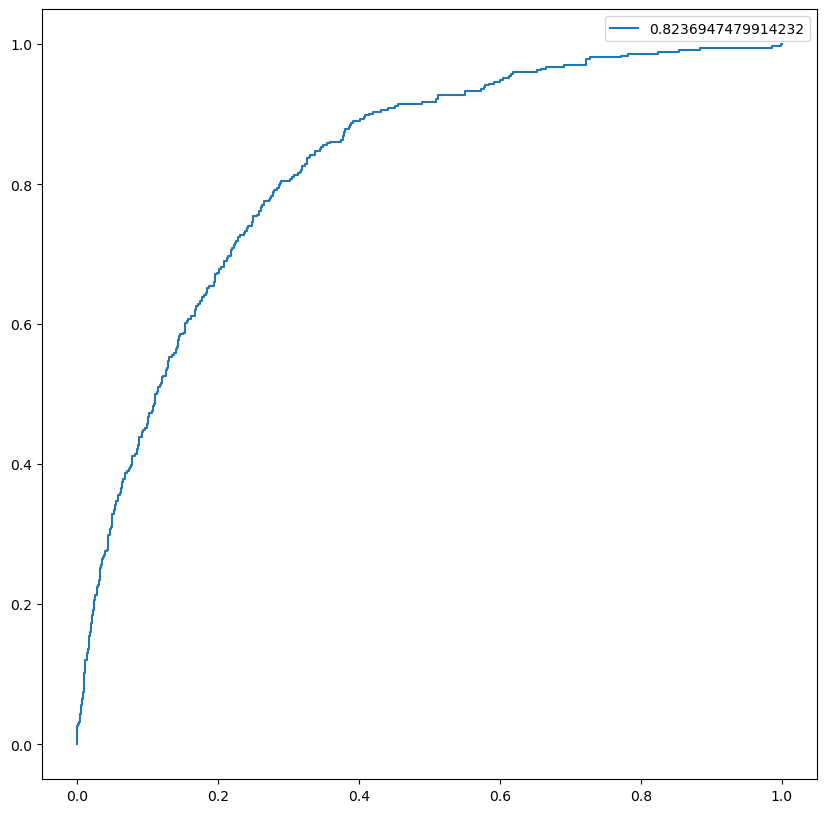

In [78]:
#selecting one of the class probabilities predicted
prob=smote_pipeline_logit.predict_proba(x_test)[:,1]
#calculating area under curve
auc=roc_auc_score(y_test,prob)
#calculating false positive rate and true positive rate
fpr,tpr,_=roc_curve(y_test,prob)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label=str(auc))
plt.legend()
plt.show()


##### The ROC curve shows good performance with 82% AUC score.
##### The classification report shows fairly  good  test accuracy for both the classes 